Relocation from Newyork to Toronto.
Find similar neighborhoods in Toronto compared to a given neighborhood in Newyork.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\TRINATHSAHU\Anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.9.11          |           py37_0         147 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         147 KB

The following packages will be UPDATED:

  certifi                                  2019.6.16-py37_1 --> 2019.9.11-py37_0




certifi-2019.9.11    | 147 KB    |            |   0% 
certifi-2019.9.11    | 147 KB    | #          |  11% 
certifi-2019.9.11    | 147 KB    | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Solving environment: ...working... done

# All requested packages already ins

Get latitudes and longitudes of newyork newighborhoods

In [2]:
with open('nyu_2451_34572-geojson.json') as json_data:
    ny_data1 = json.load(json_data)

ny_data1

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [4]:
ny_data2 = ny_data1['features']
ny_data2[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_data = pd.DataFrame(columns=column_names)

for data in ny_data2:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_data = ny_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

ny_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(ny_data['Borough'].unique()),
        ny_data.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


This problem is to find similar neighorhoods in Toronoto compared to current neighborhood in Newyork. 
So, input a neighborhood in Newyork.

In [13]:
in_borough='Bronx'
in_neighborhood='Wakefield'
ny_curr_neighborhood = ny_data[(ny_data.Borough==in_borough) & (ny_data.Neighborhood==in_neighborhood)]
ny_curr_neighborhood

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201

In [14]:
CLIENT_ID = '0QY0WIMOGWCRPAVCD5IDOGUKXC55Q3SGWDBXTIKHMLQANTZZ' # your Foursquare ID
CLIENT_SECRET = 'O4POD0BO4RDVMU4GBRSYBB5OE1NDD431PRYKRMZGPVO0CUZB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0QY0WIMOGWCRPAVCD5IDOGUKXC55Q3SGWDBXTIKHMLQANTZZ
CLIENT_SECRET:O4POD0BO4RDVMU4GBRSYBB5OE1NDD431PRYKRMZGPVO0CUZB


Call Foursquare API to get venues nearby current Newyork neighborhood

In [17]:

LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    ny_curr_neighborhood.loc[0,'Latitude'], 
    ny_curr_neighborhood.loc[0,'Longitude'], 
    radius, 
    LIMIT)
url # display URL

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5dbd6df6dd70c5002c2257dc'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Wakefield',
  'headerFullLocation': 'Wakefield, Bronx',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 8,
  'suggestedBounds': {'ne': {'lat': 40.899205181110005,
    'lng': -73.84125857127495},
   'sw': {'lat': 40.89020517211, 'lng': -73.8531424698231}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c537892fd2ea593cb077a28',
       'name': 'Lollipops Gelato',
       'location': {'address': '4120 Baychester Ave',
        'crossStreet': 'Edenwald & Bussing Ave',
        'lat': 40.894123150205274,
        'lng': -73.84589162362325,
        'labeledLatLn

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
# type your answer here

ny_curr_neighborhood_venues = getNearbyVenues(names=ny_curr_neighborhood['Neighborhood'],
                                   latitudes=ny_curr_neighborhood['Latitude'],
                                   longitudes=ny_curr_neighborhood['Longitude']
                                  )


Wakefield


In [53]:
ny_curr_neighborhood_venues

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   
5    Wakefield              40.894705              -73.847201   
6    Wakefield              40.894705              -73.847201   
7    Wakefield              40.894705              -73.847201   

                                     Venue  Venue Latitude  Venue Longitude  \
0                         Lollipops Gelato       40.894123       -73.845892   
1                                 Rite Aid       40.896649       -73.844846   
2                         Carvel Ice Cream       40.890487       -73.848568   
3                                    Shell       40.894187       -73.845862   
4                                  Dunkin'       40.890459       -73.849089   
5                                   SUBWAY       40.890656       -73.849192   
6  Cooler Runnings Jamaican Restaurant Inc       40.898276       -73.850381   
7                          Koss Quick Wash       40.891281       -73.849904   

         Venue Category  
0          Dessert Shop  
1              Pharmacy  
2        Ice Cream Shop  
3           Gas Station  
4            Donut Shop  
5        Sandwich Place  
6  Caribbean Restaurant  
7            Laundromat

In [23]:
# one hot encoding
ny_curr_neighborhood_onehot = pd.get_dummies(ny_curr_neighborhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_curr_neighborhood_onehot['Neighborhood'] = ny_curr_neighborhood_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_curr_neighborhood_onehot.columns[-1]] + list(ny_curr_neighborhood_onehot.columns[:-1])
ny_curr_neighborhood_onehot = ny_curr_neighborhood_onehot[fixed_columns]

ny_curr_neighborhood_onehot.head()

Neighborhood  Caribbean Restaurant  Dessert Shop  Donut Shop  Gas Station  \
0    Wakefield                     0             1           0            0   
1    Wakefield                     0             0           0            0   
2    Wakefield                     0             0           0            0   
3    Wakefield                     0             0           0            1   
4    Wakefield                     0             0           1            0   

   Ice Cream Shop  Laundromat  Pharmacy  Sandwich Place  
0               0           0         0               0  
1               0           0         1               0  
2               1           0         0               0  
3               0           0         0               0  
4               0           0         0               0

In [24]:
ny_curr_neighborhood_grouped = ny_curr_neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
ny_curr_neighborhood_grouped

Neighborhood  Caribbean Restaurant  Dessert Shop  Donut Shop  Gas Station  \
0    Wakefield                 0.125         0.125       0.125        0.125   

   Ice Cream Shop  Laundromat  Pharmacy  Sandwich Place  
0           0.125       0.125     0.125           0.125

In [26]:
ny_curr_neighborhood_grouped.shape

(1, 9)

 Scrap the Wikipedia website https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and 
            store the table portion of the PostalCode, Borough and Neighborhood (Toronot city) in a Pandas Dataframe.

In [27]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
list1=pd.read_html(url)

toronto_neigh=list1[0][1:]
toronto_neigh.head()

0                 1                 2
1  M1A      Not assigned      Not assigned
2  M2A      Not assigned      Not assigned
3  M3A        North York         Parkwoods
4  M4A        North York  Victoria Village
5  M5A  Downtown Toronto      Harbourfront

 Clean up the data. Add column names to the dataframe. 
 Since problem asks to ignore the cells which has Borough as 'Not assigned', remove those rows form the datafra,
 

In [28]:
toronto_neigh.columns=['PostalCode','Borough', 'Neighborhood']
toronto_neigh=toronto_neigh[toronto_neigh.Borough != 'Not assigned']
print (toronto_neigh.shape)
toronto_neigh.head()

(211, 3)


PostalCode           Borough      Neighborhood
3        M3A        North York         Parkwoods
4        M4A        North York  Victoria Village
5        M5A  Downtown Toronto      Harbourfront
6        M5A  Downtown Toronto       Regent Park
7        M6A        North York  Lawrence Heights

Check if there are any rows which has Neighborhood as 'Not assigned'

In [29]:
toronto_neigh[toronto_neigh.Neighborhood=='Not assigned']

PostalCode       Borough  Neighborhood
9        M7A  Queen's Park  Not assigned

Since there are such row exists which has Neighborhood=='Not assigned', as per question, copy the 
respective value from 'Borough' column. I.e, the neighborhood will be the same as the borough. 

In [30]:
toronto_neigh['Neighborhood'] = np.where((toronto_neigh['Neighborhood'] =='Not assigned'),
                                toronto_neigh['Borough'],      #This is the value that is inserted
                                toronto_neigh['Neighborhood'])  
toronto_neigh.head()

PostalCode           Borough      Neighborhood
3        M3A        North York         Parkwoods
4        M4A        North York  Victoria Village
5        M5A  Downtown Toronto      Harbourfront
6        M5A  Downtown Toronto       Regent Park
7        M6A        North York  Lawrence Heights

Now check to confirm there are no rows where Neighborhood=='Not assigned'

In [31]:
toronto_neigh[toronto_neigh.Neighborhood=='Not assigned']

Empty DataFrame
Columns: [PostalCode, Borough, Neighborhood]
Index: []

Confirm that the M7A row which had 'Not assigned' value before, is same as Borough value now.

In [32]:
toronto_neigh[toronto_neigh.PostalCode=='M7A']

PostalCode       Borough  Neighborhood
9        M7A  Queen's Park  Queen's Park

In [33]:
toronto_neigh.shape

(211, 3)

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma. 

In [34]:
toronto_neigh=toronto_neigh.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index()


Below is answer to Question#1

In [35]:
toronto_neigh

PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
93         M9A         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
98         M9N              York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood  
0                                        Rouge,Malvern  
1                 Highland Creek,Rouge Hill,Port Union  
2                      Guildwood,Morningside,West Hill  
3                              

Print the shape of the dataframe

In [36]:
toronto_neigh.shape

(103, 3)

Use the given Geospatial_Coordinates.csv file for the latitude and longitudes

In [37]:
latlon=pd.read_csv('Geospatial_Coordinates.csv')
latlon.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [38]:
latlon.dtypes

Postal Code     object
Latitude       float64
Longitude      float64
dtype: object

In [39]:
toronto_neigh.head()

PostalCode      Borough                          Neighborhood
0        M1B  Scarborough                         Rouge,Malvern
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union
2        M1E  Scarborough       Guildwood,Morningside,West Hill
3        M1G  Scarborough                                Woburn
4        M1H  Scarborough                             Cedarbrae

In [40]:
#toronto_neigh2 = pd.concat([toronto_neigh, latlon], axis=1, join='inner')
toronto_neigh2 = pd.merge(toronto_neigh, latlon, left_on='PostalCode',right_on='Postal Code')
toronto_neigh2.drop("Postal Code", axis = 1, inplace=True)
toronto_neigh2.head()

PostalCode      Borough                          Neighborhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3        M1G  Scarborough                                Woburn  43.770992   
4        M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

Below is answer to Question#2

In [41]:
print (toronto_neigh2.shape)
toronto_neigh2

(103, 5)


PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
16         M1X       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
21         M2M        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
93         M9A         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
98         M9N              York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood   Latitude  Longitude  
0                                        Rouge,Malvern  43.806686 -79.194353  
1                 Highland Creek,Rouge Hill,Port Union  43.784535 -79.160497  
2                     

Lets Explore and cluster the neighborhoods in 'Toronto'. 

In [42]:
downt_data=toronto_neigh2
downt_data.head()

PostalCode      Borough                          Neighborhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3        M1G  Scarborough                                Woburn  43.770992   
4        M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

In [43]:
downt_data.shape

(103, 5)

In [1]:
address = 'Toronto'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

Display neighbours in Toronto using Folium map. Add popup label for each neighbor so that when neighbor circle is clicked it pops up a text having name of the neighborhood

In [46]:
# create map of Manhattan using latitude and longitude values
map_downt = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(downt_data['Latitude'], downt_data['Longitude'], downt_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downt)  
    
map_downt

Initialize parameters to call the Foursquare API

In [47]:
CLIENT_ID = '0QY0WIMOGWCRPAVCD5IDOGUKXC55Q3SGWDBXTIKHMLQANTZZ' # your Foursquare ID
CLIENT_SECRET = 'O4POD0BO4RDVMU4GBRSYBB5OE1NDD431PRYKRMZGPVO0CUZB' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0QY0WIMOGWCRPAVCD5IDOGUKXC55Q3SGWDBXTIKHMLQANTZZ
CLIENT_SECRET:O4POD0BO4RDVMU4GBRSYBB5OE1NDD431PRYKRMZGPVO0CUZB


In [48]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [49]:
# type your answer here

downt_venues = getNearbyVenues(names=downt_data['Neighborhood'],
                                   latitudes=downt_data['Latitude'],
                                   longitudes=downt_data['Longitude']
                                  )


Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

Now, lets display top 5 rows to ensure data has been returned and stored properly

In [50]:
print(downt_venues.shape)
downt_venues.head()

(2252, 7)


Neighborhood  Neighborhood Latitude  \
0                         Rouge,Malvern              43.806686   
1  Highland Creek,Rouge Hill,Port Union              43.784535   
2       Guildwood,Morningside,West Hill              43.763573   
3       Guildwood,Morningside,West Hill              43.763573   
4       Guildwood,Morningside,West Hill              43.763573   

   Neighborhood Longitude                            Venue  Venue Latitude  \
0              -79.194353                          Wendy's       43.807448   
1              -79.160497            Royal Canadian Legion       43.782533   
2              -79.188711  Swiss Chalet Rotisserie & Grill       43.767697   
3              -79.188711                G & G Electronics       43.765309   
4              -79.188711                 Big Bite Burrito       43.766299   

   Venue Longitude        Venue Category  
0       -79.199056  Fast Food Restaurant  
1       -79.163085                   Bar  
2       -79.189914           Pizza Place  
3       -79.191537     Electronics Store  
4       -79.190720    Mexican Restaurant

Groupby Neighborhoods and display count of venues in each neighborhood

In [51]:
downt_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Adelaide,King,Richmond                                                100   
Agincourt                                                               5   
Agincourt North,L'Amoreaux East,Milliken,Steele...                      3   
Albion Gardens,Beaumond Heights,Humbergate,Jame...                      8   
Alderwood,Long Branch                                                   8   
Bathurst Manor,Downsview North,Wilson Heights                          18   
Bayview Village                                                         4   
Bedford Park,Lawrence Manor East                                       25   
Berczy Park                                                            56   
Birch Cliff,Cliffside West                                              4   
Bloordale Gardens,Eringate,Markland Wood,Old Bu...                      6   
Brockton,Exhibition Place,Parkdale Village                             22   
Business Reply Mail Processing Centre 969 Eastern                      17   
CFB Toronto,Downsview East                                              2   
CN Tower,Bathurst Quay,Island airport,Harbourfr...                     14   
Cabbagetown,St. James Town                                             44   
Caledonia-Fairbanks                                                     5   
Canada Post Gateway Processing Centre                                  11   
Cedarbrae                                                               7   
Central Bay Street                                                     83   
Chinatown,Grange Park,Kensington Market                                94   
Christie                                                               18   
Church and Wellesley                                                   88   
Clairlea,Golden Mile,Oakridge                                           9   
Clarks Corners,Sullivan,Tam O'Shanter                                  11   
Cliffcrest,Cliffside,Scarborough Village West                           2   
Cloverdale,Islington,Martin Grove,Princess Gard...                      1   
Commerce Court,Victoria Hotel                                         100   
Davisville                                                             35   
Davisville North                                                        9   
Deer Park,Forest Hill SE,Rathnelly,South Hill,S...                     15   
Del Ray,Keelesdale,Mount Dennis,Silverthorn                             4   
Design Exchange,Toronto Dominion Centre                               100   
Don Mills North                                                         5   
Dorset Park,Scarborough Town Centre,Wexford Hei...                      7   
Dovercourt Village,Dufferin                                            15   
Downsview Central                                                       4   
Downsview Northwest                                                     5   
Downsview West                                                          5   
Downsview,North Park,Upwood Park                                        4   
East Birchmount Park,Ionview,Kennedy Park                               4   
East Toronto                                                            4   
Emery,Humberlea                                                         1   
Fairview,Henry Farm,Oriole                                             65   
First Canadian Place,Underground city                                 100   
Flemingdon Park,Don Mills South                                        21   
Forest Hill North,Forest Hill West                                      4   
Glencairn                                                               6   
Guildwood,Morningside,West Hill                                         9   
Harbord,University of Toronto                                          36   
Harbourfront East,Toronto Islands,Union Station 

Lets see how many unique venue categories are there in the neghborhood of 'Toronto'

In [52]:
print('There are {} uniques categories.'.format(len(downt_venues['Venue Category'].unique())))

There are 274 uniques categories.


We need to merge current Newyork neighborhood details and Toronto all neighborhood details, so that clustering can be done together

In [57]:
downt_venues = pd.concat([ny_curr_neighborhood_venues,downt_venues])
downt_venues.head(20)

Neighborhood  Neighborhood Latitude  \
0                              Wakefield              40.894705   
1                              Wakefield              40.894705   
2                              Wakefield              40.894705   
3                              Wakefield              40.894705   
4                              Wakefield              40.894705   
5                              Wakefield              40.894705   
6                              Wakefield              40.894705   
7                              Wakefield              40.894705   
0                          Rouge,Malvern              43.806686   
1   Highland Creek,Rouge Hill,Port Union              43.784535   
2        Guildwood,Morningside,West Hill              43.763573   
3        Guildwood,Morningside,West Hill              43.763573   
4        Guildwood,Morningside,West Hill              43.763573   
5        Guildwood,Morningside,West Hill              43.763573   
6        Guildwood,Morningside,West Hill              43.763573   
7        Guildwood,Morningside,West Hill              43.763573   
8        Guildwood,Morningside,West Hill              43.763573   
9        Guildwood,Morningside,West Hill              43.763573   
10       Guildwood,Morningside,West Hill              43.763573   
11                                Woburn              43.770992   

    Neighborhood Longitude                                    Venue  \
0               -73.847201                         Lollipops Gelato   
1               -73.847201                                 Rite Aid   
2               -73.847201                         Carvel Ice Cream   
3               -73.847201                                    Shell   
4               -73.847201                                  Dunkin'   
5               -73.847201                                   SUBWAY   
6               -73.847201  Cooler Runnings Jamaican Restaurant Inc   
7               -73.847201                          Koss Quick Wash   
0               -79.194353                                  Wendy's   
1               -79.160497                    Royal Canadian Legion   
2               -79.188711          Swiss Chalet Rotisserie & Grill   
3               -79.188711                        G & G Electronics   
4               -79.188711                         Big Bite Burrito   
5               -79.188711                             chatr Mobile   
6               -79.188711                    Enterprise Rent-A-Car   
7               -79.188711                 Wood Floor Polishing Inc   
8               -79.188711                    Woburn Medical Centre   
9               -79.188711             Lawrence Ave E & Kingston Rd   
10              -79.188711                                 Eggsmart   
11              -79.216917                                Starbucks   

    Venue Latitude  Venue Longitude        Venue Category  
0        40.894123       -73.845892          Dessert Shop  
1        40.896649       -73.844846              Pharmacy  
2        40.890487       -73.848568        Ice Cream Shop  
3        40.894187       -73.845862           Gas Station  
4        40.890459       -73.849089            Donut Shop  
5        40.890656       -73.849192        Sandwich Place  
6        40.898276       -73.850381  Caribbean Restaurant  
7        40.891281       -73.849904            Laundromat  
0        43.807448       -79.199056  Fast Food Restaurant  
1        43.782533       -79.163085                   Bar  
2        43.767697       -79.189914           Pizza Place  
3        43.765309       -79.191537     Electronics Store  
4        43.766299       -79.190720    Mexican Restaurant  
5        43.766140       -79.191630     Electronics Store  
6        43.764076       -79.193406   Rental Car Location  
7        43.766500       -79.185207         Moving Target  
8        43.766631       -79.192286        Medical Center  
9        43.767704       -79.189490          Int

Convert the venue categories to columns by using onehot coding so that it can be inputted to K-means clustering algorithm

In [58]:
# one hot encoding
downt_onehot = pd.get_dummies(downt_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
downt_onehot['Neighborhood'] = downt_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [downt_onehot.columns[-1]] + list(downt_onehot.columns[:-1])
downt_onehot = downt_onehot[fixed_columns]

downt_onehot.head()

Yoga Studio  Accessories Store  Afghan Restaurant  Airport  \
0            0                  0                  0        0   
1            0                  0                  0        0   
2            0                  0                  0        0   
3            0                  0                  0        0   
4            0                  0                  0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Antique Shop  Aquarium  Art Gallery  Art Museum  \
0                    0             0         0            0           0   
1                    0             0         0            0           0   
2                    0             0         0            0           0   
3                    0             0         0            0           0   
4                    0             0         0            0           0   

   Arts & Crafts Store  Asian Restaurant  Athletics & Sports  Auto Garage  \
0                    0                 0                   0            0   
1                    0                 0                   0            0   
2                    0                 0                   0            0   
3                    0                 0                   0            0   
4                    0                 0                   0            0   

   Auto Workshop  BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank  Bar  \
0              0          0           0           0       0     0    0   
1              0          0           0           0       0     0    0   
2              0          0           0           0       0     0    0   
3              0          0           0           0       0     0    0   
4              0          0           0           0       0     0    0   

   Baseball Field  Baseball Stadium  Basketball Court  Basketball Stadium  \
0               0                 0                 0                   0   
1               0                 0                 0                   0   
2               0                 0                 0                   0   
3               0                 0                 0                   0   
4               0                 0                 0                   0   

   Beach  Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  \
0      0                0         0           0                   0   
1      0                0         0           0                   0   
2      0                0         0           0                   0   
3      0                0         0           0                   0   
4      0                0         0           0                   0   

   Bike Shop  Bistro  Boat or Ferry  Bookstore  Boutique  \
0          0       0              0          0         0   
1          0       0              0          0         0   
2          0       0              0          0         0   
3          0       0              0          0         0   
4          0       0              0          0         0   

   Brazilian Restaurant  Breakfast Spot  Brewery  Bridal Shop  \
0                     0               0        0            0   
1                     0               0        0            0   
2                     0               0        0            0   
3                     0               0        0            0   
4                     0               0        0            0   

   Bubble Tea Shop  Building  Burger Joint  Burrito Place  Bus Line  \
0                0         0             0              0         0   
1           

In [59]:
downt_onehot.shape

(2260, 276)

Calculate average of venue count of same venue categories

In [60]:
downt_grouped = downt_onehot.groupby('Neighborhood').mean().reset_index()
downt_grouped

Neighborhood  Yoga Studio  \
0                              Adelaide,King,Richmond     0.000000   
1                                           Agincourt     0.000000   
2   Agincourt North,L'Amoreaux East,Milliken,Steel...     0.000000   
3   Albion Gardens,Beaumond Heights,Humbergate,Jam...     0.000000   
4                               Alderwood,Long Branch     0.000000   
5       Bathurst Manor,Downsview North,Wilson Heights     0.000000   
6                                     Bayview Village     0.000000   
7                    Bedford Park,Lawrence Manor East     0.000000   
8                                         Berczy Park     0.000000   
9                          Birch Cliff,Cliffside West     0.000000   
10  Bloordale Gardens,Eringate,Markland Wood,Old B...     0.000000   
11         Brockton,Exhibition Place,Parkdale Village     0.000000   
12  Business Reply Mail Processing Centre 969 Eastern     0.000000   
13                         CFB Toronto,Downsview East     0.000000   
14  CN Tower,Bathurst Quay,Island airport,Harbourf...     0.000000   
15                         Cabbagetown,St. James Town     0.000000   
16                                Caledonia-Fairbanks     0.000000   
17              Canada Post Gateway Processing Centre     0.000000   
18                                          Cedarbrae     0.000000   
19                                 Central Bay Street     0.012048   
20            Chinatown,Grange Park,Kensington Market     0.000000   
21                                           Christie     0.000000   
22                               Church and Wellesley     0.011364   
23                      Clairlea,Golden Mile,Oakridge     0.000000   
24              Clarks Corners,Sullivan,Tam O'Shanter     0.000000   
25      Cliffcrest,Cliffside,Scarborough Village West     0.000000   
26  Cloverdale,Islington,Martin Grove,Princess Gar...     0.000000   
27                      Commerce Court,Victoria Hotel     0.000000   
28                                         Davisville     0.000000   
29                                   Davisville North     0.000000   
30  Deer Park,Forest Hill SE,Rathnelly,South Hill,...     0.000000   
31        Del Ray,Keelesdale,Mount Dennis,Silverthorn     0.000000   
32            Design Exchange,Toronto Dominion Centre     0.000000   
33                                    Don Mills North     0.000000   
34  Dorset Park,Scarborough Town Centre,Wexford He...     0.000000   
35                        Dovercourt Village,Dufferin     0.000000   
36                                  Downsview Central     0.000000   
37                                Downsview Northwest     0.000000   
38                                     Downsview West     0.000000   
39                   Downsview,North Park,Upwood Park     0.000000   
40          East Birchmount Park,Ionview,Kennedy Park     0.000000   
41                                       East Toronto     0.000000   
42                                    Emery,Humberlea     0.000000   
43                         Fairview,Henry Farm,Oriole     0.000000   
44              First Canadian Place,Underground city     0.000000   
45                    Flemingdon Park,Don Mills South     0.000000   
46                 Forest Hill North,Forest Hill West     0.000000   
47                                          Glencairn     0.000000   
48                    Guildwood,Morningside,West Hill     0.000000   
49                      Harbord,University of Toronto     0.055556   
50    Harbourfront East,Toronto Islands,Union Station     0.000000   
51                           Harbourfront,Regent Park     0.019608   
52                       High Park,The Junction South     0.000000   
53               Highland Creek,Rouge Hill,Port Union     0.000000   
54                                  Hillcrest Village     0.000000   
55         Humber Bay Shores,Mimico South,New Toronto     0.000000   
56  Humber Bay,King's Mill Park,Kingsway Park Sout.

In [61]:
downt_grouped.shape

(100, 276)

Lets see what are the top 5 venues in each neighborhood

In [62]:
num_top_venues = 5

for hood in downt_grouped['Neighborhood']:
    #print("----"+hood+"----")
    temp = downt_grouped[downt_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    #print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    #print('\n')

In [63]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create a new dataframe with top 10 common venues for each neighborhood

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = downt_grouped['Neighborhood']

for ind in np.arange(downt_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(downt_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                             Adelaide,King,Richmond           Coffee Shop   
1                                          Agincourt        Sandwich Place   
2  Agincourt North,L'Amoreaux East,Milliken,Steel...                  Park   
3  Albion Gardens,Beaumond Heights,Humbergate,Jam...         Grocery Store   
4                              Alderwood,Long Branch           Pizza Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                  Café                   Bar      Sushi Restaurant   
1                Lounge          Skating Rink        Breakfast Spot   
2            Playground            Donut Shop          Dessert Shop   
3   Fried Chicken Joint              Pharmacy           Pizza Place   
4           Coffee Shop                   Gym          Skating Rink   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                 Hotel            Steakhouse      Asian Restaurant   
1            Print Shop         Women's Store    Dim Sum Restaurant   
2    Dim Sum Restaurant                 Diner        Discount Store   
3  Fast Food Restaurant            Beer Store        Sandwich Place   
4              Pharmacy                   Pub        Sandwich Place   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0       Thai Restaurant   American Restaurant                 Bakery  
1                 Diner        Discount Store                Dog Run  
2               Dog Run      Doner Restaurant              Drugstore  
3               Dog Run          Dessert Shop     Dim Sum Restaurant  
4        Discount Store      Department Store           Dessert Shop

In [65]:
neighborhoods_venues_sorted

Neighborhood  \
0                              Adelaide,King,Richmond   
1                                           Agincourt   
2   Agincourt North,L'Amoreaux East,Milliken,Steel...   
3   Albion Gardens,Beaumond Heights,Humbergate,Jam...   
4                               Alderwood,Long Branch   
5       Bathurst Manor,Downsview North,Wilson Heights   
6                                     Bayview Village   
7                    Bedford Park,Lawrence Manor East   
8                                         Berczy Park   
9                          Birch Cliff,Cliffside West   
10  Bloordale Gardens,Eringate,Markland Wood,Old B...   
11         Brockton,Exhibition Place,Parkdale Village   
12  Business Reply Mail Processing Centre 969 Eastern   
13                         CFB Toronto,Downsview East   
14  CN Tower,Bathurst Quay,Island airport,Harbourf...   
15                         Cabbagetown,St. James Town   
16                                Caledonia-Fairbanks   
17              Canada Post Gateway Processing Centre   
18                                          Cedarbrae   
19                                 Central Bay Street   
20            Chinatown,Grange Park,Kensington Market   
21                                           Christie   
22                               Church and Wellesley   
23                      Clairlea,Golden Mile,Oakridge   
24              Clarks Corners,Sullivan,Tam O'Shanter   
25      Cliffcrest,Cliffside,Scarborough Village West   
26  Cloverdale,Islington,Martin Grove,Princess Gar...   
27                      Commerce Court,Victoria Hotel   
28                                         Davisville   
29                                   Davisville North   
30  Deer Park,Forest Hill SE,Rathnelly,South Hill,...   
31        Del Ray,Keelesdale,Mount Dennis,Silverthorn   
32            Design Exchange,Toronto Dominion Centre   
33                                    Don Mills North   
34  Dorset Park,Scarborough Town Centre,Wexford He...   
35                        Dovercourt Village,Dufferin   
36                                  Downsview Central   
37                                Downsview Northwest   
38                                     Downsview West   
39                   Downsview,North Park,Upwood Park   
40          East Birchmount Park,Ionview,Kennedy Park   
41                                       East Toronto   
42                                    Emery,Humberlea   
43                         Fairview,Henry Farm,Oriole   
44              First Canadian Place,Underground city   
45                    Flemingdon Park,Don Mills South   
46                 Forest Hill North,Forest Hill West   
47                                          Glencairn   
48                    Guildwood,Morningside,West Hill   
49                      Harbord,University of Toronto   
50    Harbourfront East,Toronto Islands,Union Station   
51                           Harbourfront,Regent Park   
52                       High Park,The Junction South   
53               Highland Creek,Rouge Hill,Port Union   
54                                  Hillcrest Village   
55         Humber Bay Shores,Mimico South,New Toronto   
56  Humber Bay,King's Mill Park,Kingsway Park Sout...   
57                                      Humber Summit   
58                                 Humewood-Cedarvale   
59  Kingsview Village,Martin Grove Gardens,Richvie...   
60  Kingsway Park South West,Mimico NW,The Queensw...   
61                                    L'Amoreaux West   
62                    Lawrence Heights,Lawrence Manor   
63                                      Lawrence Park   
64                                            Leaside   
65                            Little Portugal,Trinity   
66                                   Maryvale,Wexford   
67                         Moore Park,Summerhill East   
68                                 North Toronto West   
69                                          Northwe

In [66]:
neighborhoods_venues_sorted.shape

(100, 11)

In [71]:
downt_grouped.shape

(100, 276)

In [72]:
downt_grouped.head()

Neighborhood  Yoga Studio  \
0                             Adelaide,King,Richmond          0.0   
1                                          Agincourt          0.0   
2  Agincourt North,L'Amoreaux East,Milliken,Steel...          0.0   
3  Albion Gardens,Beaumond Heights,Humbergate,Jam...          0.0   
4                              Alderwood,Long Branch          0.0   

   Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0                0.0                0.0      0.0                 0.0   
1                0.0                0.0      0.0                 0.0   
2                0.0                0.0      0.0                 0.0   
3                0.0                0.0      0.0                 0.0   
4                0.0                0.0      0.0                 0.0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0             0.0              0.0               0.0                 0.03   
1             0.0              0.0               0.0                 0.00   
2             0.0              0.0               0.0                 0.00   
3             0.0              0.0               0.0                 0.00   
4             0.0              0.0               0.0                 0.00   

   Antique Shop  Aquarium  Art Gallery  Art Museum  Arts & Crafts Store  \
0           0.0       0.0         0.01        0.01                  0.0   
1           0.0       0.0         0.00        0.00                  0.0   
2           0.0       0.0         0.00        0.00                  0.0   
3           0.0       0.0         0.00        0.00                  0.0   
4           0.0       0.0         0.00        0.00                  0.0   

   Asian Restaurant  Athletics & Sports  Auto Garage  Auto Workshop  \
0              0.03                 0.0          0.0            0.0   
1              0.00                 0.0          0.0            0.0   
2              0.00                 0.0          0.0            0.0   
3              0.00                 0.0          0.0            0.0   
4              0.00                 0.0          0.0            0.0   

   BBQ Joint  Baby Store  Bagel Shop  Bakery  Bank   Bar  Baseball Field  \
0        0.0         0.0         0.0    0.03   0.0  0.04             0.0   
1        0.0         0.0         0.0    0.00   0.0  0.00             0.0   
2        0.0         0.0         0.0    0.00   0.0  0.00             0.0   
3        0.0         0.0         0.0    0.00   0.0  0.00             0.0   
4        0.0         0.0         0.0    0.00   0.0  0.00             0.0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Beach  \
0               0.0               0.0                 0.0    0.0   
1               0.0               0.0                 0.0    0.0   
2               0.0               0.0                 0.0    0.0   
3               0.0               0.0                 0.0    0.0   
4               0.0               0.0                 0.0    0.0   

   Bed & Breakfast  Beer Bar  Beer Store  Belgian Restaurant  Bike Shop  \
0              0.0       0.0       0.000                 0.0        0.0   
1              0.0       0.0       0.000                 0.0        0.0   
2              0.0       0.0       0.000                 0.0        0.0   
3              0.0       0.0       0.125                 0.0        0.0   
4              0.0       0.0       0.000                 0.0        0.0   

   Bistro  Boat or Ferry  Bookstore  Boutique  Brazilian Restaurant  \
0     0.0            0.0       0.01       0.0                  0.01   
1     0.0            0.0       0.00       0.0                  0.00   
2     0.0            0.0       0.00       0.0                  0.00   
3     0.0            0.0       0.00       0.0                  0.00   
4     0.0            0.0       0.00       0.0                  0.00   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Building  \
0            0.02      0.0          0

Now is the time to create a model of Kmeans algorithm and fit the data which has all the venues in all the neighborhood of 'Toronto'

In [183]:
Ks=16
wcss= np.zeros((Ks-1))
for i in range(1, Ks):
    kmeans2 = KMeans(n_clusters = i, init = 'k-means++',random_state = 42).fit(downt_grouped_clustering)
    wcss[i-1]=kmeans2.inertia_


Check for optimal K-value and select the optimum one.

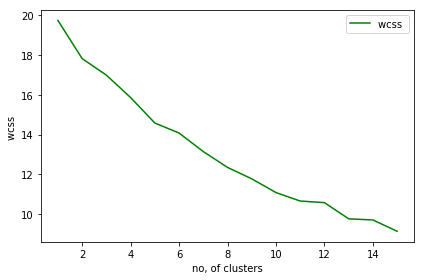

In [186]:
import matplotlib.pyplot as plt 
plt.plot(range(1,Ks),wcss,'g') 
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc,alpha=0.10) 
plt.legend(('wcss ', '+/- 3xstd')) 
plt.ylabel('wcss ') 
plt.xlabel('no, of clusters') 
plt.tight_layout() 
plt.show()


In [161]:
# set number of clusters
kclusters = 15

downt_grouped_clustering = downt_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 8, 2, 5, 0, 0, 8, 0, 0, 0])

In [162]:
downt_grouped_clustering

Yoga Studio  Accessories Store  Afghan Restaurant   Airport  \
0      0.000000           0.000000           0.000000  0.000000   
1      0.000000           0.000000           0.000000  0.000000   
2      0.000000           0.000000           0.000000  0.000000   
3      0.000000           0.000000           0.000000  0.000000   
4      0.000000           0.000000           0.000000  0.000000   
5      0.000000           0.000000           0.000000  0.000000   
6      0.000000           0.000000           0.000000  0.000000   
7      0.000000           0.000000           0.000000  0.000000   
8      0.000000           0.000000           0.000000  0.000000   
9      0.000000           0.000000           0.000000  0.000000   
10     0.000000           0.000000           0.000000  0.000000   
11     0.000000           0.000000           0.000000  0.000000   
12     0.000000           0.000000           0.000000  0.000000   
13     0.000000           0.000000           0.000000  0.500000   
14     0.000000           0.000000           0.000000  0.071429   
15     0.000000           0.000000           0.000000  0.000000   
16     0.000000           0.000000           0.000000  0.000000   
17     0.000000           0.000000           0.000000  0.000000   
18     0.000000           0.000000           0.000000  0.000000   
19     0.012048           0.000000           0.000000  0.000000   
20     0.000000           0.000000           0.000000  0.000000   
21     0.000000           0.000000           0.000000  0.000000   
22     0.011364           0.000000           0.011364  0.000000   
23     0.000000           0.000000           0.000000  0.000000   
24     0.000000           0.000000           0.000000  0.000000   
25     0.000000           0.000000           0.000000  0.000000   
26     0.000000           0.000000           0.000000  0.000000   
27     0.000000           0.000000           0.000000  0.000000   
28     0.000000           0.000000           0.000000  0.000000   
29     0.000000           0.000000           0.000000  0.000000   
30     0.000000           0.000000           0.000000  0.000000   
31     0.000000           0.000000           0.000000  0.000000   
32     0.000000           0.000000           0.000000  0.000000   
33     0.000000           0.000000           0.000000  0.000000   
34     0.000000           0.000000           0.000000  0.000000   
35     0.000000           0.000000           0.000000  0.000000   
36     0.000000           0.000000           0.000000  0.000000   
37     0.000000           0.000000           0.000000  0.000000   
38     0.000000           0.000000           0.000000  0.000000   
39     0.000000           0.000000           0.000000  0.000000   
40     0.000000           0.000000           0.000000  0.000000   
41     0.000000           0.000000           0.000000  0.000000   
42     0.000000           0.000000           0.000000  0.000000   
43     0.000000           0.000000           0.000000  0.000000   
44     0.000000           0.000000           0.000000  0.000000   
45     0.000000           0.000000           0.000000  0.000000   
46     0.000000           0.000000           0.000000  0.000000   
47     0.000000           0.000000           0.000000  0.000000   
48     0.000000           0.000000           0.000000  0.000000   
49     0.055556           0.000000           0.000000  0.000000   
50     0.000000           0.000000           0.000000  0.000000   
51     0.019608           0.000000           0.000000  0.000000   
52     0.000000           0.000000           0.000000  0.000000   
53     0.000000           0.000000           0.000000  0.000000   
54     0.000000           0.000000           0.000000  0.000000   
55     0.000000           0.000000           0.000000  0.000000   
56     0.000000           0.000000           0.000000  0.000000   
57     0.000000           0.000000           0.000000  0.000000   
58     0.000000           0.000000           0.0000

Add the Cluster label to the dataframe so that we can clearly see which venue falls into which cluster

In [164]:
neighborhoods_venues_sorted.drop("Cluster Labels", axis = 1, inplace=True)

In [165]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

downt_merged = downt_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
downt_merged = downt_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

downt_merged.head() # check the last columns!

PostalCode      Borough                          Neighborhood   Latitude  \
0        M1B  Scarborough                         Rouge,Malvern  43.806686   
1        M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2        M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3        M1G  Scarborough                                Woburn  43.770992   
4        M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.194353             3.0  Fast Food Restaurant             Drugstore   
1 -79.160497             6.0                   Bar         Women's Store   
2 -79.188711             8.0     Electronics Store    Mexican Restaurant   
3 -79.216917            14.0           Coffee Shop     Indian Restaurant   
4 -79.239476             8.0      Hakka Restaurant                Bakery   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Dim Sum Restaurant                 Diner        Discount Store   
1             Drugstore                 Diner        Discount Store   
2         Moving Target   Rental Car Location           Pizza Place   
3     Korean Restaurant         Women's Store             Drugstore   
4                  Bank    Athletics & Sports  Caribbean Restaurant   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0               Dog Run      Doner Restaurant            Donut Shop   
1               Dog Run      Doner Restaurant            Donut Shop   
2        Breakfast Spot          Intersection        Medical Center   
3                 Diner        Discount Store               Dog Run   
4       Thai Restaurant   Fried Chicken Joint         Women's Store   

  9th Most Common Venue 10th Most Common Venue  
0   Dumpling Restaurant            College Gym  
1   Dumpling Restaurant           Dessert Shop  
2    Dim Sum Restaurant                  Diner  
3      Doner Restaurant             Donut Shop  
4               Dog Run                  Diner

In [167]:
downt_merged.dropna(inplace=True)
downt_merged

PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood   Latitude  Longitude  \
0                                        Rouge,Malvern  43.806686 -79.194353   
1                 Highland Creek,Rouge Hill,Port Union  43.784535 -79.160497   
2                      Guildwood,Morningside,West Hill  43.763573 -79.188711   
3                                               Woburn  43.770992 -79.216917   
4  

In [168]:
neighborhoods_venues_sorted

Cluster Labels                                       Neighborhood  \
0                0                             Adelaide,King,Richmond   
1                8                                          Agincourt   
2                2  Agincourt North,L'Amoreaux East,Milliken,Steel...   
3                5  Albion Gardens,Beaumond Heights,Humbergate,Jam...   
4                0                              Alderwood,Long Branch   
5                0      Bathurst Manor,Downsview North,Wilson Heights   
6                8                                    Bayview Village   
7                0                   Bedford Park,Lawrence Manor East   
8                0                                        Berczy Park   
9                0                         Birch Cliff,Cliffside West   
10               0  Bloordale Gardens,Eringate,Markland Wood,Old B...   
11               0         Brockton,Exhibition Place,Parkdale Village   
12               8  Business Reply Mail Processing Centre 969 Eastern   
13               2                         CFB Toronto,Downsview East   
14               0  CN Tower,Bathurst Quay,Island airport,Harbourf...   
15               0                         Cabbagetown,St. James Town   
16               2                                Caledonia-Fairbanks   
17               0              Canada Post Gateway Processing Centre   
18               8                                          Cedarbrae   
19               0                                 Central Bay Street   
20               0            Chinatown,Grange Park,Kensington Market   
21               0                                           Christie   
22               0                               Church and Wellesley   
23               8                      Clairlea,Golden Mile,Oakridge   
24               8              Clarks Corners,Sullivan,Tam O'Shanter   
25               9      Cliffcrest,Cliffside,Scarborough Village West   
26              10  Cloverdale,Islington,Martin Grove,Princess Gar...   
27               0                      Commerce Court,Victoria Hotel   
28               0                                         Davisville   
29               8                                   Davisville North   
30               0  Deer Park,Forest Hill SE,Rathnelly,South Hill,...   
31               8        Del Ray,Keelesdale,Mount Dennis,Silverthorn   
32               0            Design Exchange,Toronto Dominion Centre   
33               8                                    Don Mills North   
34               8  Dorset Park,Scarborough Town Centre,Wexford He...   
35               8                        Dovercourt Village,Dufferin   
36              13                                  Downsview Central   
37               8                                Downsview Northwest   
38               8                                     Downsview West   
39               8                   Downsview,North Park,Upwood Park   
40               0          East Birchmount Park,Ionview,Kennedy Park   
41               2                                       East Toronto   
42               4                                    Emery,Humberlea   
43               0                         Fairview,Henry Farm,Oriole   
44               0              First Canadian Place,Underground city   
45               0                    Flemingdon Park,Don Mills South   
46               8                 Forest Hill North,Forest Hill West   
47               8                                          Glencairn   
48               8                    Guildwood,Morningside,West Hill   
49               0                      Harbord,University of Toronto   
50               0    Harbourfront East,Toronto Islands,Union Station   
51               0                           Harbourfront,Regent Park   
52               8                       High Park,The Junction South   
53               6               Highland Creek,Rouge Hill,Por

In [171]:
similar_neighborhood_cluster=neighborhoods_venues_sorted[neighborhoods_venues_sorted.Neighborhood==in_neighborhood]['Cluster Labels']

In [175]:
similar_neighborhood_cluster

92    8
Name: Cluster Labels, dtype: int32

In [173]:
downt_merged

PostalCode           Borough  \
0          M1B       Scarborough   
1          M1C       Scarborough   
2          M1E       Scarborough   
3          M1G       Scarborough   
4          M1H       Scarborough   
5          M1J       Scarborough   
6          M1K       Scarborough   
7          M1L       Scarborough   
8          M1M       Scarborough   
9          M1N       Scarborough   
10         M1P       Scarborough   
11         M1R       Scarborough   
12         M1S       Scarborough   
13         M1T       Scarborough   
14         M1V       Scarborough   
15         M1W       Scarborough   
17         M2H        North York   
18         M2J        North York   
19         M2K        North York   
20         M2L        North York   
22         M2N        North York   
23         M2P        North York   
24         M2R        North York   
25         M3A        North York   
26         M3B        North York   
27         M3C        North York   
28         M3H        North York   
29         M3J        North York   
30         M3K        North York   
31         M3L        North York   
32         M3M        North York   
33         M3N        North York   
34         M4A        North York   
35         M4B         East York   
36         M4C         East York   
37         M4E      East Toronto   
38         M4G         East York   
39         M4H         East York   
40         M4J         East York   
41         M4K      East Toronto   
42         M4L      East Toronto   
43         M4M      East Toronto   
44         M4N   Central Toronto   
45         M4P   Central Toronto   
46         M4R   Central Toronto   
47         M4S   Central Toronto   
48         M4T   Central Toronto   
49         M4V   Central Toronto   
50         M4W  Downtown Toronto   
51         M4X  Downtown Toronto   
52         M4Y  Downtown Toronto   
53         M5A  Downtown Toronto   
54         M5B  Downtown Toronto   
55         M5C  Downtown Toronto   
56         M5E  Downtown Toronto   
57         M5G  Downtown Toronto   
58         M5H  Downtown Toronto   
59         M5J  Downtown Toronto   
60         M5K  Downtown Toronto   
61         M5L  Downtown Toronto   
62         M5M        North York   
63         M5N   Central Toronto   
64         M5P   Central Toronto   
65         M5R   Central Toronto   
66         M5S  Downtown Toronto   
67         M5T  Downtown Toronto   
68         M5V  Downtown Toronto   
69         M5W  Downtown Toronto   
70         M5X  Downtown Toronto   
71         M6A        North York   
72         M6B        North York   
73         M6C              York   
74         M6E              York   
75         M6G  Downtown Toronto   
76         M6H      West Toronto   
77         M6J      West Toronto   
78         M6K      West Toronto   
79         M6L        North York   
80         M6M              York   
81         M6N              York   
82         M6P      West Toronto   
83         M6R      West Toronto   
84         M6S      West Toronto   
85         M7A      Queen's Park   
86         M7R       Mississauga   
87         M7Y      East Toronto   
88         M8V         Etobicoke   
89         M8W         Etobicoke   
90         M8X         Etobicoke   
91         M8Y         Etobicoke   
92         M8Z         Etobicoke   
94         M9B         Etobicoke   
95         M9C         Etobicoke   
96         M9L        North York   
97         M9M        North York   
99         M9P         Etobicoke   
100        M9R         Etobicoke   
101        M9V         Etobicoke   
102        M9W         Etobicoke   

                                          Neighborhood   Latitude  Longitude  \
0                                        Rouge,Malvern  43.806686 -79.194353   
1                 Highland Creek,Rouge Hill,Port Union  43.784535 -79.160497   
2                      Guildwood,Morningside,West Hill  43.763573 -79.188711   
3                                               Woburn  43.770992 -79.216917   
4  

Display the neighborhoods in Toronoto which are similar to current neighborhood of the person in Newyork(which in this example is 'Wakefield').

In [181]:
downt_merged[downt_merged['Cluster Labels']==int(similar_neighborhood_cluster)]

PostalCode          Borough  \
2         M1E      Scarborough   
4         M1H      Scarborough   
7         M1L      Scarborough   
10        M1P      Scarborough   
11        M1R      Scarborough   
12        M1S      Scarborough   
13        M1T      Scarborough   
15        M1W      Scarborough   
17        M2H       North York   
19        M2K       North York   
26        M3B       North York   
31        M3L       North York   
33        M3N       North York   
35        M4B        East York   
36        M4C        East York   
37        M4E     East Toronto   
39        M4H        East York   
42        M4L     East Toronto   
45        M4P  Central Toronto   
48        M4T  Central Toronto   
63        M5N  Central Toronto   
64        M5P  Central Toronto   
72        M6B       North York   
73        M6C             York   
76        M6H     West Toronto   
79        M6L       North York   
80        M6M             York   
82        M6P     West Toronto   
87        M7Y     East Toronto   
92        M8Z        Etobicoke   

                                         Neighborhood   Latitude  Longitude  \
2                     Guildwood,Morningside,West Hill  43.763573 -79.188711   
4                                           Cedarbrae  43.773136 -79.239476   
7                       Clairlea,Golden Mile,Oakridge  43.711112 -79.284577   
10  Dorset Park,Scarborough Town Centre,Wexford He...  43.757410 -79.273304   
11                                   Maryvale,Wexford  43.750072 -79.295849   
12                                          Agincourt  43.794200 -79.262029   
13              Clarks Corners,Sullivan,Tam O'Shanter  43.781638 -79.304302   
15                                    L'Amoreaux West  43.799525 -79.318389   
17                                  Hillcrest Village  43.803762 -79.363452   
19                                    Bayview Village  43.786947 -79.385975   
26                                    Don Mills North  43.745906 -79.352188   
31                                     Downsview West  43.739015 -79.506944   
33                                Downsview Northwest  43.761631 -79.520999   
35                     Woodbine Gardens,Parkview Hill  43.706397 -79.309937   
36                                   Woodbine Heights  43.695344 -79.318389   
37                                        The Beaches  43.676357 -79.293031   
39                                   Thorncliffe Park  43.705369 -79.349372   
42                      The Beaches West,India Bazaar  43.668999 -79.315572   
45                                   Davisville North  43.712751 -79.390197   
48                         Moore Park,Summerhill East  43.689574 -79.383160   
63                                           Roselawn  43.711695 -79.416936   
64                 Forest Hill North,Forest Hill West  43.696948 -79.411307   
72                                          Glencairn  43.709577 -79.445073   
73                                 Humewood-Cedarvale  43.693781 -79.428191   
76                        Dovercourt Village,Dufferin  43.669005 -79.442259   
79                   Downsview,North Park,Upwood Park  43.713756 -79.490074   
80        Del Ray,Keelesdale,Mount Dennis,Silverthorn  43.691116 -79.476013   
82                       High Park,The Junction South  43.661608 -79.464763   
87  Business Reply Mail Processing Centre 969 Eastern  43.662744 -79.321558   
92  Kingsway Park South West,Mimico NW,The Queensw...  43.628841 -79.520999   

    Cluster Labels     1st Most Common Venue  2nd Most Common Venue  \
2              8.0         Electronics Store     Mexican Restaurant   
4              8.0          Hakka Restaurant                 Bakery   
7              8.0                    Bakery               Bus Line   
10             8.0         Indian Restaurant              Pet Store   
11             8.0               Auto Garage  Vietnamese Restaurant   
12             8.0            Sandwich Place                 Lounge   
1

Bets way to present the output is via map. So, lets use folium map to visualize the clustering and segmentation of the neighborhoods in 'Toronoto". Use differnet color for different cluster so that it is easy to disinguish. Add popup label for each neighborhood. Also, add a legend to highlight the color of similar neighborhoods.

In [177]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.5)
import numpy as np

colors2 = [
    'red',
    'blue',
    'gray',
    'darkred',
    'lightred',
    'orange',
    'beige',
    'green',
    'darkgreen',
    'lightgreen',
    'darkblue',
    'lightblue',
    'purple',
    'darkpurple',
    'pink',
    'cadetblue',
    'lightgray',
    'black'
]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(downt_merged['Latitude'], downt_merged['Longitude'], downt_merged['Neighborhood'], downt_merged['Cluster Labels']):
    text1 = poi + ' Cluster ' + cluster.__str__()
    label = folium.Popup(text1, parse_html=True)
    if cluster ==float(similar_neighborhood_cluster):
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=colors[0],
            fill=True,
            fill_color=colors2[0],
            fill_opacity=0.7).add_to(map_clusters)
    else:
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,            
            color=colors2[int(cluster)+1],
            fill=True,
            fill_color=colors2[int(cluster)+1],
            fill_opacity=0.7).add_to(map_clusters)


legend_html = '''
     <div style="position: fixed; 
     bottom: 200px; right: 70px; width: 200px; height: 100px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     ">&nbsp;Similar neighborhoods in Toronto<br>
     &nbsp; <svg height="30" width="30">
      <circle cx="15" cy="15" r="10" stroke="red" stroke-width="3" fill="red" />
      </svg><br>
        
                  
     </div>
     '''
    
map_clusters.get_root().html.add_child(folium.Element(legend_html))

map_clusters

So, in above map, red ones are the recommended neighborhoods in Toronoto which are similar to current newyork neighborhood 'Wakefield'.